In [4]:
# train_ctown_lstm_tf.py
import os, mlflow, mlflow.tensorflow
import pandas as pd, numpy as np, tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ----------------- CONFIG -----------------
root_p = '/mnt/data/home/zayd/Digital_twin_project/machine_learning'
CSV_PATH = f"{root_p}/dataset/leakage/ctown_leak_dataset.csv"
MODEL_DIR = f"{root_p}/model_trained"
EXPERIMENT_NAME = "Leakage_Detection"

WINDOW, STRIDE, BATCH, EPOCHS = 12, 3, 64, 30
LR, RANDOM = 1e-3, 42
ALGO_NAME = "LSTM"   # <- changeable for other models later
# ------------------------------------------

# Ensure experiment
mlflow.set_experiment(EXPERIMENT_NAME)

# ------------- DATA LOADING ----------------
df = pd.read_csv(CSV_PATH)
leak_df = df[df.leak == 1]
noleak_df = df[df.leak == 0].sample(len(leak_df), random_state=RANDOM)
df = pd.concat([leak_df, noleak_df]).sample(frac=1, random_state=RANDOM)

if 'Unnamed: 0' in df.columns: df = df.rename(columns={'Unnamed: 0':'t'})
if 't' not in df.columns:
    df['t'] = df.groupby('scenario_id').cumcount()

feat_cols = [c for c in df.columns if c.startswith(('P_','Q_','H_'))]
label_col = 'leak'
sc_ids = df['scenario_id'].dropna().unique()

tr_ids, te_ids = train_test_split(sc_ids, test_size=0.2, random_state=RANDOM)
tr_ids, va_ids = train_test_split(tr_ids, test_size=0.2, random_state=RANDOM)

def make_windows(sub):
    sub = sub.sort_values('t')
    Xraw, yraw = sub[feat_cols].values, sub[label_col].values
    X, y = [], []
    for i in range(0, len(sub)-WINDOW+1, STRIDE):
        X.append(Xraw[i:i+WINDOW]); y.append(yraw[i+WINDOW-1])
    return np.array(X), np.array(y)

def pack(ids):
    partsX, partsy = [], []
    for sid in ids:
        Xc, yc = make_windows(df[df.scenario_id==sid])
        if len(Xc): partsX.append(Xc); partsy.append(yc)
    return np.vstack(partsX), np.hstack(partsy)

Xtr, ytr = pack(tr_ids); Xva, yva = pack(va_ids); Xte, yte = pack(te_ids)

scaler = StandardScaler().fit(Xtr.reshape(-1, Xtr.shape[-1]))
scale = lambda X: scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
Xtr, Xva, Xte = scale(Xtr), scale(Xva), scale(Xte)

In [3]:
# ------------- MLflow RUN -----------------
with mlflow.start_run(run_name=ALGO_NAME):
    mlflow.log_params({
        "algo": ALGO_NAME, "window": WINDOW, "stride": STRIDE,
        "batch": BATCH, "epochs": EPOCHS, "lr": LR
    })

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(WINDOW, Xtr.shape[-1])),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(LR),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Precision(name='prec'),
                           tf.keras.metrics.Recall(name='rec')])

    cb = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max',
                                           patience=5, restore_best_weights=True)]
    mlflow.tensorflow.autolog()  # <- track everything automatically

    history = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                        epochs=EPOCHS, batch_size=BATCH, callbacks=cb, verbose=1)

    test_metrics = model.evaluate(Xte, yte, batch_size=BATCH, verbose=0)
    metric_names = ["loss", "auc", "prec", "rec"]
    for name, val in zip(metric_names, test_metrics):
        mlflow.log_metric(f"test_{name}", float(val))

    save_path = os.path.join(MODEL_DIR, f"leakage_{ALGO_NAME.lower()}.keras")
    model.save(save_path)
    mlflow.log_artifact(save_path)


2025-09-02 09:02:20.817975: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.7422 - loss: 0.5678 - prec: 0.7262 - rec: 0.7493

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - auc: 0.7448 - loss: 0.5656 - prec: 0.7279 - rec: 0.7521 - val_auc: 0.8995 - val_loss: 0.4006 - val_prec: 0.8605 - val_rec: 0.8717
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - auc: 0.9611 - loss: 0.2759 - prec: 0.8947 - rec: 0.9211 - val_auc: 0.8887 - val_loss: 0.4357 - val_prec: 0.8746 - val_rec: 0.8037
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.9916 - loss: 0.1487 - prec: 0.9542 - rec: 0.9714

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.9915 - loss: 0.1488 - prec: 0.9541 - rec: 0.9714 - val_auc: 0.9115 - val_loss: 0.3805 - val_prec: 0.8245 - val_rec: 0.9346
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9987 - loss: 0.0883 - prec: 0.9705 - rec: 0.9915 - val_auc: 0.9008 - val_loss: 0.4567 - val_prec: 0.8761 - val_rec: 0.8141
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - auc: 0.9999 - loss: 0.0456 - prec: 0.9896 - rec: 0.9978 - val_auc: 0.8786 - val_loss: 0.5010 - val_prec: 0.8443 - val_rec: 0.8377
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - auc: 0.9999 - loss: 0.0285 - prec: 0.9948 - rec: 0.9969 - val_auc: 0.8543 - val_loss: 0.6354 - val_prec: 0.8383 - val_rec: 0.7330
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - auc: 1.0000 - loss: 0.0211 - prec: 0.9966 - rec: 0.9994 - val_auc: 0.8882 - val_loss: 0.5471 - val_prec: 0.8602 - val_rec: 0.8377
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - auc: 1.0000 - loss: 0.0090 - prec: 0.9992 -

2025/09/02 09:02:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [4]:
import os, mlflow, mlflow.tensorflow
from tensorflow.keras import layers, models, optimizers, callbacks, metrics

EXPERIMENT_NAME = "Leakage_Detection"
ALGO_NAME = "Stacked_LSTM"   # or "Stacked_GRU"
MODEL_DIR = "/mnt/data/home/zayd/Digital_twin_project/machine_learning/model_trained"

mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=ALGO_NAME):
    mlflow.log_params({
        "algo": ALGO_NAME,
        "window": WINDOW, "stride": STRIDE,
        "batch": BATCH, "epochs": EPOCHS, "lr": LR
    })

    model = models.Sequential([
        layers.Input(shape=(WINDOW, Xtr.shape[-1])),

        # LSTM stack
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.4),
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.4),

        # Or switch to GRUs:
        # layers.GRU(128, return_sequences=True),
        # layers.Dropout(0.3),
        # layers.GRU(64, return_sequences=False),
        # layers.Dropout(0.3),

        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=optimizers.Adam(LR),
        loss="binary_crossentropy",
        metrics=[metrics.AUC(name="auc"),
                 metrics.Precision(name="prec"),
                 metrics.Recall(name="rec")]
    )

    cb = [callbacks.EarlyStopping(monitor="val_auc", mode="max",
                                  patience=6, restore_best_weights=True)]

    mlflow.tensorflow.autolog()

    model.fit(Xtr, ytr, validation_data=(Xva, yva),
              epochs=EPOCHS, batch_size=BATCH, callbacks=cb, verbose=1)

    test_metrics = model.evaluate(Xte, yte, batch_size=BATCH, verbose=0)
    for name, val in zip(["loss", "auc", "prec", "rec"], test_metrics):
        mlflow.log_metric(f"test_{name}", float(val))

    save_path = os.path.join(MODEL_DIR, f"leakage_{ALGO_NAME.lower()}.keras")
    model.save(save_path)
    mlflow.log_artifact(save_path)


Epoch 1/30
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.6599 - loss: 0.6423 - prec: 0.6628 - rec: 0.8268

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - auc: 0.6647 - loss: 0.6399 - prec: 0.6651 - rec: 0.8299 - val_auc: 0.8437 - val_loss: 0.4897 - val_prec: 0.8106 - val_rec: 0.8848
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.8636 - loss: 0.4606 - prec: 0.8322 - rec: 0.8886

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - auc: 0.8638 - loss: 0.4601 - prec: 0.8323 - rec: 0.8888 - val_auc: 0.8728 - val_loss: 0.4285 - val_prec: 0.8460 - val_rec: 0.8482
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - auc: 0.9234 - loss: 0.3474 - prec: 0.8631 - rec: 0.9109 - val_auc: 0.8434 - val_loss: 0.5124 - val_prec: 0.8015 - val_rec: 0.8455
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.9695 - loss: 0.2123 - prec: 0.9268 - rec: 0.9599 - val_auc: 0.8069 - val_loss: 0.6884 - val_prec: 0.7909 - val_rec: 0.8220
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - auc: 0.9848 - loss: 0.1451 - prec: 0.9538 - rec: 0.9678 - val_auc: 0.8427 - val_loss: 0.7132 - val_prec: 0.8563 - val_rec: 0.7330
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - auc: 0.9916 - loss: 0.1087 - prec: 0.9620 - rec: 0.9720 - val_auc: 0.8464 - val_loss: 0.7386 - val_prec: 0.8447 - val_rec: 0.8115
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - auc: 0.9962 - loss: 0.0666 - prec: 0.9797 -

2025/09/02 09:03:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [5]:
import os, mlflow, mlflow.tensorflow
from tensorflow.keras import layers, models, callbacks, optimizers, metrics

EXPERIMENT_NAME = "Leakage_Detection"
ALGO_NAME = "Stacked_GRU"
MODEL_DIR = "/mnt/data/home/zayd/Digital_twin_project/machine_learning/model_trained"

mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=ALGO_NAME):
    mlflow.log_params({
        "algo": ALGO_NAME,
        "window": WINDOW, "stride": STRIDE,
        "batch": 64, "epochs": 30, "lr": 1e-3
    })

    # Build model
    model = models.Sequential()
    model.add(layers.GRU(64, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])))
    model.add(layers.Dropout(0.4))
    model.add(layers.GRU(32, return_sequences=False))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[metrics.AUC(name="auc"),
                 metrics.Precision(name="prec"),
                 metrics.Recall(name="rec")]
    )

    # Early stopping
    early_stop = callbacks.EarlyStopping(
        monitor="val_auc", patience=6, restore_best_weights=True
    )

    mlflow.tensorflow.autolog()

    # Train
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=30,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate & log
    test_metrics = model.evaluate(Xte, yte, verbose=0)
    for name, val in zip(["loss", "auc", "prec", "rec"], test_metrics):
        mlflow.log_metric(f"test_{name}", float(val))

    # Save
    save_path = os.path.join(MODEL_DIR, "leakage_gru_1.keras")
    model.save(save_path)
    mlflow.log_artifact(save_path)


/home/zayd/Desktop/Digital_twin_project/digitaltwin/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.6313 - loss: 0.6363 - prec: 0.6689 - rec: 0.8143

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - auc: 0.6331 - loss: 0.6356 - prec: 0.6696 - rec: 0.8145 - val_auc: 0.8555 - val_loss: 0.5137 - val_prec: 0.8321 - val_rec: 0.9084
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8306 - loss: 0.4971 - prec: 0.7865 - rec: 0.8895

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - auc: 0.8309 - loss: 0.4968 - prec: 0.7866 - rec: 0.8893 - val_auc: 0.8836 - val_loss: 0.4219 - val_prec: 0.8656 - val_rec: 0.8770
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - auc: 0.8997 - loss: 0.3959 - prec: 0.8574 - rec: 0.9019 - val_auc: 0.8889 - val_loss: 0.4523 - val_prec: 0.8882 - val_rec: 0.7906
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9491 - loss: 0.2850 - prec: 0.8985 - rec: 0.9243 - val_auc: 0.8922 - val_loss: 0.4265 - val_prec: 0.8403 - val_rec: 0.8953
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - auc: 0.9867 - loss: 0.1564 - prec: 0.9420 - rec: 0.9745 - val_auc: 0.8642 - val_loss: 0.5948 - val_prec: 0.8525 - val_rec: 0.8168
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - auc: 0.9869 - loss: 0.1352 - prec: 0.9558 - rec: 0.9675 - val_auc: 0.8919 - val_loss: 0.4802 - val_prec: 0.8579 - val_rec: 0.8691
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - auc: 0.9974 - loss: 0.0677 - prec: 0.9865 -

2025/09/02 09:04:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [8]:
import os, mlflow, joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, log_loss

EXPERIMENT_NAME = "Leakage_Detection"
MODEL_DIR = "/mnt/data/home/zayd/Digital_twin_project/machine_learning/model_trained"

mlflow.set_experiment(EXPERIMENT_NAME)

# --- Random Forest ---
ALGO_NAME = "Random_Forest"
with mlflow.start_run(run_name=ALGO_NAME):
    params = {
        "algo": ALGO_NAME,
        "window": WINDOW,
        "stride": STRIDE,
        "n_estimators": 100,
        "max_depth": None,
        "random_state": 42
    }
    mlflow.log_params(params)

    rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
    rf_model.fit(Xtr.reshape(Xtr.shape[0], -1), ytr)

    y_pred_prob = rf_model.predict_proba(Xte.reshape(Xte.shape[0], -1))[:, 1]
    y_pred = rf_model.predict(Xte.reshape(Xte.shape[0], -1))

    # Log metrics like TensorFlow models
    mlflow.log_metric("test_loss", log_loss(yte, y_pred_prob))
    mlflow.log_metric("test_auc", roc_auc_score(yte, y_pred_prob))
    mlflow.log_metric("test_prec", precision_score(yte, y_pred))
    mlflow.log_metric("test_rec", recall_score(yte, y_pred))

    # Save artifact
    save_path = os.path.join(MODEL_DIR, "leakage_rf.joblib")
    joblib.dump(rf_model, save_path)
    mlflow.log_artifact(save_path)

In [2]:
!mlflow ui

[2025-09-02 18:35:47 +0100] [16722] [INFO] Starting gunicorn 23.0.0
[2025-09-02 18:35:47 +0100] [16722] [INFO] Listening at: http://127.0.0.1:5000 (16722)
[2025-09-02 18:35:47 +0100] [16722] [INFO] Using worker: sync
[2025-09-02 18:35:47 +0100] [16723] [INFO] Booting worker with pid: 16723
[2025-09-02 18:35:47 +0100] [16724] [INFO] Booting worker with pid: 16724
[2025-09-02 18:35:47 +0100] [16725] [INFO] Booting worker with pid: 16725
[2025-09-02 18:35:47 +0100] [16726] [INFO] Booting worker with pid: 16726
[2025-09-02 21:06:48 +0100] [16722] [INFO] Handling signal: int
^C

Aborted!
[2025-09-02 21:06:48 +0100] [16725] [INFO] Worker exiting (pid: 16725)
[2025-09-02 21:06:48 +0100] [16726] [INFO] Worker exiting (pid: 16726)
[2025-09-02 21:06:48 +0100] [16724] [INFO] Worker exiting (pid: 16724)
[2025-09-02 21:06:48 +0100] [16723] [INFO] Worker exiting (pid: 16723)


In [9]:
# --- Logistic Regression ---
ALGO_NAME = "Logistic_Regression"
with mlflow.start_run(run_name=ALGO_NAME):
    params = {
        "algo": ALGO_NAME,
        "window": WINDOW,
        "stride": STRIDE,
        "solver": "lbfgs",
        "max_iter": 500,
        "random_state": 42
    }
    mlflow.log_params(params)

    lr_model = LogisticRegression(solver="lbfgs", max_iter=500, random_state=42)
    lr_model.fit(Xtr.reshape(Xtr.shape[0], -1), ytr)

    y_pred_prob = lr_model.predict_proba(Xte.reshape(Xte.shape[0], -1))[:, 1]
    y_pred = lr_model.predict(Xte.reshape(Xte.shape[0], -1))

    mlflow.log_metric("test_loss", log_loss(yte, y_pred_prob))
    mlflow.log_metric("test_auc", roc_auc_score(yte, y_pred_prob))
    mlflow.log_metric("test_prec", precision_score(yte, y_pred))
    mlflow.log_metric("test_rec", recall_score(yte, y_pred))

    save_path = os.path.join(MODEL_DIR, "leakage_lr.joblib")
    joblib.dump(lr_model, save_path)
    mlflow.log_artifact(save_path)

In [6]:
import os, mlflow, joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, log_loss
import numpy as np

EXPERIMENT_NAME = "Leakage_Detection"
MODEL_DIR = "/mnt/data/home/zayd/Digital_twin_project/machine_learning/model_trained"
mlflow.set_experiment(EXPERIMENT_NAME)

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
top_models = []

# Loop over all hyperparameter combinations
for hp in ParameterGrid(param_grid):
    fold_metrics = []
    for train_idx, val_idx in kf.split(Xtr):
        X_train_fold, X_val_fold = Xtr[train_idx].reshape(len(train_idx), -1), Xtr[val_idx].reshape(len(val_idx), -1)
        y_train_fold, y_val_fold = ytr[train_idx], ytr[val_idx]

        model = RandomForestClassifier(**hp, random_state=42)
        model.fit(X_train_fold, y_train_fold)

        y_val_prob = model.predict_proba(X_val_fold)[:, 1]
        y_val_pred = model.predict(X_val_fold)

        metrics_fold = [
            log_loss(y_val_fold, y_val_prob),
            roc_auc_score(y_val_fold, y_val_prob),
            precision_score(y_val_fold, y_val_pred),
            recall_score(y_val_fold, y_val_pred)
        ]
        fold_metrics.append(metrics_fold)

    avg_metrics = np.mean(fold_metrics, axis=0)
    top_models.append({"hp": hp, "avg_metrics": avg_metrics})

# Select top 2 models by mean validation AUC
top_models_sorted = sorted(top_models, key=lambda x: x["avg_metrics"][1], reverse=True)[:2]

# Log top 2 models to MLflow
for rank, m in enumerate(top_models_sorted, start=1):
    ALGO_NAME = f"Random_Forest2_{rank}"
    model = RandomForestClassifier(**m["hp"], random_state=42)
    model.fit(Xtr.reshape(Xtr.shape[0], -1), ytr)

    y_pred_prob = model.predict_proba(Xte.reshape(Xte.shape[0], -1))[:, 1]
    y_pred = model.predict(Xte.reshape(Xte.shape[0], -1))

    with mlflow.start_run(run_name=ALGO_NAME):
        mlflow.log_params({
            "algo": ALGO_NAME,
            "window": WINDOW,
            "stride": STRIDE,
            **m["hp"]
        })
        mlflow.log_metric("test_loss", log_loss(yte, y_pred_prob))
        mlflow.log_metric("test_auc", roc_auc_score(yte, y_pred_prob))
        mlflow.log_metric("test_prec", precision_score(yte, y_pred))
        mlflow.log_metric("test_rec", recall_score(yte, y_pred))

        save_path = os.path.join(MODEL_DIR, f"leakage_{ALGO_NAME}.joblib")
        joblib.dump(model, save_path)
        mlflow.log_artifact(save_path)


In [5]:
import os, mlflow
from tensorflow.keras import layers, models, callbacks, optimizers, metrics
from sklearn.model_selection import KFold
import numpy as np

EXPERIMENT_NAME = "Leakage_Detection"
MODEL_DIR = "/mnt/data/home/zayd/Digital_twin_project/machine_learning/model_trained"
mlflow.set_experiment(EXPERIMENT_NAME)

# Hyperparameter grid to search manually
hyperparams_list = [
    {"gru1_units": 64, "gru2_units": 32, "dense_units": 32,
     "dropout1":0.4, "dropout2":0.4, "dropout3":0.3, "lr":1e-3},
    {"gru1_units": 128, "gru2_units": 64, "dense_units": 32,
     "dropout1":0.3, "dropout2":0.3, "dropout3":0.2, "lr":5e-4},
    # Add more hyperparameter combinations as needed
]

kf = KFold(n_splits=3, shuffle=True, random_state=42)
top_models = []

# --- Hyperparameter search with k-fold CV ---
for hp in hyperparams_list:
    fold_metrics = []
    for train_idx, val_idx in kf.split(Xtr):
        X_train_fold, X_val_fold = Xtr[train_idx], Xtr[val_idx]
        y_train_fold, y_val_fold = ytr[train_idx], ytr[val_idx]

        model = models.Sequential()
        model.add(layers.GRU(hp["gru1_units"], return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])))
        model.add(layers.Dropout(hp["dropout1"]))
        model.add(layers.GRU(hp["gru2_units"], return_sequences=False))
        model.add(layers.Dropout(hp["dropout2"]))
        model.add(layers.Dense(hp["dense_units"], activation="relu"))
        model.add(layers.Dropout(hp["dropout3"]))
        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=optimizers.Adam(learning_rate=hp["lr"]),
            loss="binary_crossentropy",
            metrics=[metrics.AUC(name="auc"),
                     metrics.Precision(name="prec"),
                     metrics.Recall(name="rec")]
        )

        es = callbacks.EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True)
        model.fit(X_train_fold, y_train_fold,
                  validation_data=(X_val_fold, y_val_fold),
                  epochs=30, batch_size=64,
                  callbacks=[es], verbose=0)

        val_metrics = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_metrics.append(val_metrics)

    # Average metrics across folds
    fold_metrics = np.array(fold_metrics)
    avg_metrics = np.mean(fold_metrics, axis=0)

    # Store last trained model for this hyperparameter set
    top_models.append({"hp": hp, "avg_metrics": avg_metrics, "model": model})

# --- Select top 2 models by average validation AUC ---
top_models_sorted = sorted(top_models, key=lambda x: x["avg_metrics"][1], reverse=True)[:2]

# --- Log only top 2 models to MLflow ---
for rank, m in enumerate(top_models_sorted, start=1):
    ALGO_NAME = f"Stacked_GRU_{rank}"
    with mlflow.start_run(run_name=ALGO_NAME):
        # Log hyperparameters
        mlflow.log_params({**m["hp"], "algo": ALGO_NAME, "window": WINDOW, "stride": STRIDE})

        # Log average metrics
        for name, val in zip(["loss", "auc", "prec", "rec"], m["avg_metrics"]):
            mlflow.log_metric(f"test_{name}", float(val))

        # Save model artifact
        save_path = os.path.join(MODEL_DIR, f"leakage_{ALGO_NAME}.keras")
        m["model"].save(save_path)
        mlflow.log_artifact(save_path)


2025-09-02 21:09:48.389129: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/zayd/Desktop/Digital_twin_project/digitaltwin/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
import os
file = os.listdir('/mnt/data/home/zayd/Digital_twin_project/machine_learning/model_trained/LSTM_0.0.2')
model = [mdo for mdo in file if '.keras' in mdo]
print(len(model))

19


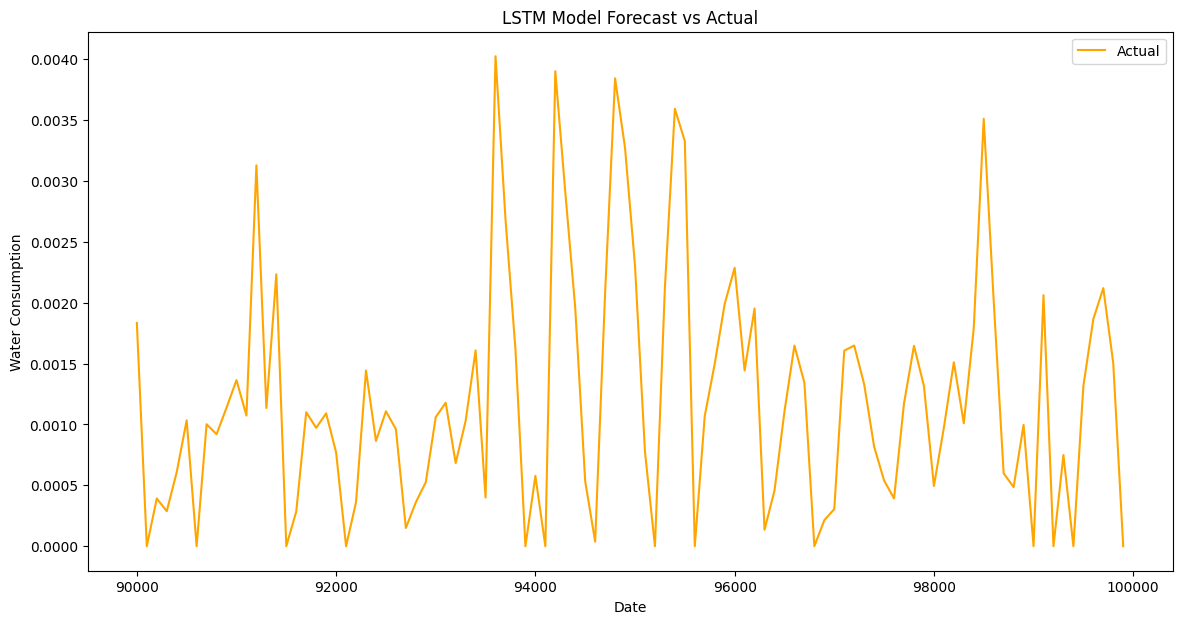

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/new_dataset.csv')

# Plot predictions
plt.figure(figsize=(14, 7))
# plt.plot(dates_train, target_scaler.inverse_transform(y_train_lstm.reshape(-1, 1)).flatten(), label='Training Data')
plt.plot(df['time'].iloc[900:1000], df['J311'].iloc[900:1000], label='Actual', color='orange')
#plt.plot(test_scenarios, y_pred_inv, label='Predicted', color='green')
plt.xlabel('Date')
plt.ylabel('Water Consumption')
plt.title('LSTM Model Forecast vs Actual')
plt.legend()
plt.show()


In [3]:
import pandas as pd


df1=pd.read_parquet('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/Ctown/junction_base_demand-0-dynamic_input.parquet')
# df_total=df1[df1['scenario_id']==980]
# df_total
# df_total.to_csv('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/Ctown/test.csv')
junction_cols = [col for col in df1.columns if col.startswith('J')]

# Convert from m³/s to L/s
df1[junction_cols] = df1[junction_cols] * 1000

# Display first 5 rows
df1.head(5)

,scenario_id,time_id,J511,J411,J414,J415,J416,J417,J418,J419,...,J299,J300,J301,J302,J304,J306,J307,J309,J317,J323
0,0.0,0.0,1.862500,2.032680,1.769529,1.835934,1.841779,2.037652,2.085718,2.477024,...,2.390828,2.088272,1.371041,0.790916,0.988468,1.088713,2.263387,2.725963,2.606375,2.633392
1,1.0,0.0,2.740644,2.604886,2.371015,2.475076,2.849946,3.151606,3.035425,3.045027,...,2.489421,2.464545,2.209581,2.130382,2.169688,2.255064,2.272680,2.213194,2.028880,2.627511
2,2.0,0.0,3.239212,3.362633,2.880884,2.910094,3.213697,3.428498,3.414423,3.585695,...,0.845575,1.052024,0.055251,0.475759,2.121597,2.540447,2.768737,3.001495,3.089970,2.859595
3,3.0,0.0,2.464919,2.392883,2.852411,3.687345,3.719307,3.044751,2.351148,2.299289,...,1.917594,2.384659,2.823911,3.174373,3.158614,3.102567,2.935311,3.088121,3.221037,3.652503
4,4.0,0.0,3.719307,2.818672,1.583873,1.712793,1.951066,1.935281,0.984966,0.040991,...,3.032851,2.916925,2.773240,3.092842,3.314087,3.612276,3.719307,3.473304,2.658845,2.519786


<function matplotlib.pyplot.show(close=None, block=None)>

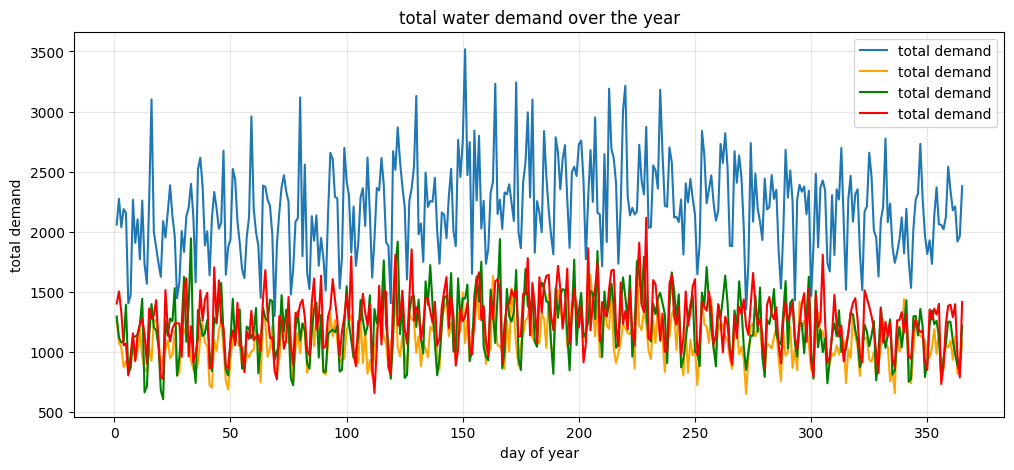

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/generated_v2.csv')
# df1=pd.read_parquet('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/junction_base_demand-0-dynamic_input.parquet')
df= df.drop(columns='Unnamed: 0')
df_total = df.groupby('day').sum(numeric_only=True)

# df_total=df.iloc[:100]
df_total.columns
# df_total=df1[df1['scenario_id']==1]
# df_total['total']=df_total.drop(columns=['scenario_id','time_id']).sum(axis=1)
df_total['total']=df_total.drop(columns=['time_id']).sum(axis=1)
df_total['total']
plt.figure(figsize=(12,5))
plt.plot(df_total.index,df_total['total'],label = "total demand")
plt.plot(df_total.index,df_total['J13']*36500,label = "total demand",color = 'orange')
plt.plot(df_total.index,df_total['J1']*35000,label = "total demand",color = 'green')
plt.plot(df_total.index,df_total['J17']*35000,label = "total demand",color = 'red')
plt.xlabel('day of year')
plt.ylabel('total demand')
plt.title('total water demand over the year')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show


In [6]:
import pandas as pd
import logging
from pathlib import Path
import os
import gc

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()]
)
root_p = '/mnt/data/home/zayd/Digital_twin_project/machine_learning'
# Load main data
# demand_0 = pd.read_parquet('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/Anytown/junction_base_demand-0-dynamic_input.parquet')
demand = pd.read_parquet('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/Anytown/junction_base_demand-0-dynamic_input.parquet')

# Combine them
# demand = pd.concat([demand_0, demand_1], ignore_index=True)
# del demand_0
# del demand_1
statics = [
    '/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/Anytown/junction_elevation-0-static_input.parquet'
]
# _=[    './dataset/pipe_diameter-0-static_input.parquet',
#     './dataset/pipe_initial_status-0-static_input.parquet',
#     './dataset/pipe_length-0-static_input.parquet',
#     './dataset/pipe_minor_loss-0-static_input.parquet',
#     './dataset/pipe_roughness-0-static_input.parquet']

links = pd.read_parquet('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/Anytown/pipes.parquet')

# Ensure output folder exists
Path("/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/Anytown/junctions_with_neighbors/").mkdir(parents=True, exist_ok=True)

demand.head()


# # static_dfs = {
# #     path: pd.read_parquet(path) for path in statics
# # }

# # Precompute neighbors for each junction
# neighbors = {}
# for j in demand.columns[demand.columns.str.startswith("J")]:
#     mask = (links['start'] == j) | (links['end'] == j)
#     near = set(links.loc[mask, 'start']).union(links.loc[mask, 'end'])
#     near.discard(j)
#     neighbors[j] = near

# for junction in demand.columns[demand.columns.str.startswith("J")]:
#     demnd = demand[['scenario_id', junction, 'time_id']].copy()
#     logging.info(f"Processing {junction}")

#     # Merge statics once
#     # for path, stat in static_dfs.items():
#     #     if junction in stat.columns:
#     #         stat_df = stat[['scenario_id', junction]].rename(columns={junction: f"{junction}_elevation"})
#     #         demnd = demnd.merge(stat_df, on="scenario_id", how="inner")

#     # Collect neighbor demands
#     dfs = []
#     for node in neighbors[junction]:
#         if node in demand.columns:
#             node_demands = (
#                 demand[['scenario_id', 'time_id', node]]
#                 .rename(columns={node: f"{node}_demand"})
#             )
#             dfs.append(node_demands)

#     if dfs:
#         # Start from demnd and join on both scenario_id + time_id
#         for nd in dfs:
#             demnd = demnd.merge(nd, on=[ "scenario_id", "time_id"], how="left")
#     demnd.to_parquet(
#         f"{root_p}/dataset/Anytown/junctions_with_neighbors/{junction}__1.parquet",
#         engine="pyarrow", index=False
#     )
    

#     logging.info(f"{junction} with {demand.shape} saved to {root_p}/dataset/junctions_with_neighbors/{junction}.parquet with {demnd.shape}")
  

,scenario_id,time_id,20,30,40,50,55,60,70,75,...,90,100,110,115,120,130,140,150,160,170
0,0.0,0.0,0.029832,0.030021,0.030290,0.029497,0.022929,0.024151,0.029010,0.028647,...,0.027695,0.027196,0.029695,0.030098,0.027722,0.031246,0.029546,0.030535,0.025926,0.022830
1,1.0,0.0,0.027364,0.025242,0.026808,0.029843,0.030487,0.029880,0.028524,0.028132,...,0.029169,0.028613,0.030041,0.027108,0.026487,0.029056,0.027126,0.027455,0.029308,0.030498
2,2.0,0.0,0.029580,0.025138,0.024256,0.028476,0.030073,0.029071,0.026513,0.023377,...,0.028431,0.029832,0.028893,0.026241,0.027421,0.028220,0.029590,0.029694,0.029965,0.027423
3,3.0,0.0,0.026757,0.029890,0.029146,0.028389,0.030143,0.028887,0.028991,0.028143,...,0.024183,0.025004,0.029965,0.027246,0.028321,0.028028,0.027269,0.029781,0.029525,0.028454
4,4.0,0.0,0.029889,0.030496,0.027892,0.028606,0.024728,0.022370,0.027113,0.029710,...,0.028871,0.029124,0.022906,0.025273,0.027161,0.022906,0.025286,0.028794,0.029740,0.029179


In [7]:
import pandas as pd
df= pd.read_parquet('/mnt/data/home/zayd/Digital_twin_project/machine_learning/dataset/junctions/J369.parquet')
df.columns

Index(['scenario_id', 'J369', 'time_id', 'J369_elevation', 'J365_demand',
       'J370_demand', 'J205_demand'],
      dtype='object')